In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import random
import zipfile
from concurrent.futures import ThreadPoolExecutor
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import albumentations as A
from torch.utils.data import DataLoader
import cv2
import numpy as np
from torch import nn
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
from clearml import Task
from dotenv import load_dotenv
from IPython.display import Image, display
from PIL import Image as PILImage
import matplotlib.pyplot as plt

from mglyph_ml.dataset.glyph_dataset import GlyphDataset
from mglyph_ml.dataset.manifest import DatasetManifest, ManifestSample
from mglyph_ml.experiment.e1.experiment import ExperimentConfig
from mglyph_ml.experiment.e1.train_model import train_and_test_model
from mglyph_ml.experiment.e1.util import load_image_into_ndarray

In [2]:
task_name = "Experiment 1.2.1"
task_tag = "exp-1.2.1"
dataset_path = Path("../data/uni.mglyph")
gap_start_x = 40.0
gap_end_x = 60.0
quick = True
seed = 420
max_epochs = 10
offline = True
batch_size = 92
data_loader_num_workers = 32
n_of_gap_samples = 1000

In [ ]:
path = Path("../data/uni.mglyph")
Task.set_offline(offline)
task: Task = Task.init(project_name="mglyph-ml", task_name=task_name)
task.add_tags(task_tag)
logger = Task.current_task().logger
load_dotenv()

ClearML Task: created new task id=offline-e7fc817c3e1c4cf48a3d53ba6f37298a
ClearML running in offline mode, session stored in /home/xgaens00/.clearml/cache/offline/offline-e7fc817c3e1c4cf48a3d53ba6f37298a


True

ClearML Task: created new task id=offline-e7fc817c3e1c4cf48a3d53ba6f37298a
ClearML running in offline mode, session stored in /home/xgaens00/.clearml/cache/offline/offline-e7fc817c3e1c4cf48a3d53ba6f37298a
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [4]:
# loading everything... this cell takes the longest time
# Load the entire zip file into memory
with open(path, "rb") as f:
    temp_archive = ZipFile(BytesIO(f.read()))

manifest_data = temp_archive.read("manifest.json")
manifest = DatasetManifest.model_validate_json(manifest_data)

samples_0 = manifest.samples["0"]  # this is where the training and validation data comes from
samples_1 = manifest.samples["1"]  # this is where the test data comes from

print(f"samples_0 count: {len(samples_0)}")
print(f"samples_1 count: {len(samples_1)}")

# Create index mappings for each subset
indices_train = [i for i, sample in enumerate(samples_0) if sample.x < gap_start_x or sample.x >= gap_end_x]
indices_gap = [i for i, sample in enumerate(samples_0) if sample.x >= gap_start_x and sample.x < gap_end_x]
indices_test = list(range(len(samples_1)))


# Load all images from memory using OpenCV (faster than PIL, directly to numpy)
def load_image_cv2(sample):
    img_bytes = temp_archive.read(sample.filename)
    img_array = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
    # OpenCV loads in BGR, convert to RGB
    return cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)


with ThreadPoolExecutor(max_workers=32) as executor:
    images_0 = list(executor.map(load_image_cv2, samples_0))
    images_1 = list(executor.map(load_image_cv2, samples_1))

temp_archive.close()

# reduce the number of validation samples
indices_gap = [i for i in indices_gap[:: len(indices_gap) // n_of_gap_samples]]


# Reference image subsets using indices
images_train = [images_0[i] for i in indices_train]
images_gap = [images_0[i] for i in indices_gap]
images_test = [images_1[i] for i in indices_test]

labels_train = [samples_0[i].x for i in indices_train]
labels_gap = [samples_0[i].x for i in indices_gap]
labels_test = [samples_1[i].x for i in indices_test]

samples_0 count: 20000
samples_1 count: 20000


Right now, the images_train might contain as little as 20000 * 0.01 = 200 samples. To combat this issue, we have to augment the data.

In [5]:
# dataset creation
affine = A.Affine(
    rotate=(-3, 3),
    translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
    fit_output=False,
    keep_ratio=True,
    border_mode=cv2.BORDER_CONSTANT,
    fill=255,
    p=1.0,
)
normalize = A.Normalize(mean=0.0, std=1.0, max_pixel_value=255.0)
to_tensor = ToTensorV2()
pipeline = A.Compose([affine, normalize, to_tensor], seed=seed)
normalize_pipeline = A.Compose([normalize, to_tensor])


def affine_and_normalize(image: np.ndarray) -> torch.Tensor:
    return pipeline(image=image)["image"]


def just_normalize(image: np.ndarray) -> torch.Tensor:
    return normalize_pipeline(image=image)["image"]


dataset_train = GlyphDataset(images=images_train, labels=labels_train, transform=affine_and_normalize)
dataset_gap = GlyphDataset(images=images_gap, labels=labels_gap, transform=just_normalize)
dataset_test = GlyphDataset(images=images_test, labels=labels_test, transform=just_normalize)

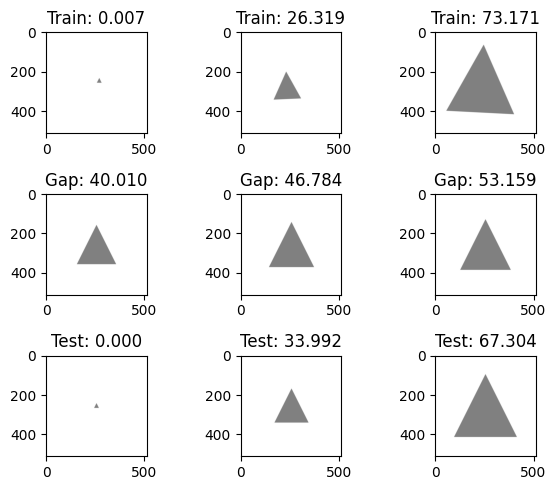

In [6]:
# Display sample images from datasets

fig, axes = plt.subplots(3, 3, figsize=(6, 5))

# Display 3 training images
for i in range(3):
    idx = i * len(dataset_train) // 3
    img_tensor, label = dataset_train[idx]
    img = img_tensor.permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Train: {label * 100.0:.3f}")

# Display 3 gap images
for i in range(3):
    idx = i * len(dataset_gap) // 3
    img_tensor, label = dataset_gap[idx]
    img = img_tensor.permute(1, 2, 0).numpy()
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Gap: {label * 100.0:.3f}")

# Display 3 test images
for i in range(3):
    idx = i * len(dataset_test) // 3
    img_tensor, label = dataset_test[idx]
    img = img_tensor.permute(1, 2, 0).numpy()
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"Test: {label * 100.0:.3f}")

plt.tight_layout()
plt.show()

In [7]:
from mglyph_ml.nn.glyph_regressor_gen2 import GlyphRegressor

device = os.environ["MGML_DEVICE"]
print(f"Training device: {device}")
model = GlyphRegressor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = model.to(device)
generator = torch.manual_seed(seed)

data_loader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    num_workers=data_loader_num_workers,
    pin_memory=True,
    shuffle=True,
)
data_loader_gap = DataLoader(
    dataset_gap,
    batch_size=batch_size,
    num_workers=data_loader_num_workers,
    pin_memory=True,
)

for epoch in range(1, max_epochs + 1):
    model.train()
    epoch_start_time = time.time()
    running_train_loss = 0.0
    running_error_train = 0.0
    num_batches = 0

    for index, data in enumerate(data_loader_train):
        inputs, labels = data
        inputs: torch.Tensor = inputs.to(device)
        labels: torch.Tensor = labels.to(device)

        inputs = inputs.float()
        labels = labels.float().view(-1, 1)

        optimizer.zero_grad()
        outputs: torch.Tensor = model(inputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()

        # Calculate accuracy as the average absolute difference (y_hat - y)
        error = torch.mean(torch.abs(outputs.float() - labels.float())).item()

        running_train_loss += loss.item()
        running_error_train += error
        num_batches += 1

        # print(f"Batch {epoch}:{index} finito with error {error}")

    error_x_train = running_error_train / num_batches * 100.0

    #  set evaluation
    model.eval()  # Set model to evaluation mode
    running_loss_gap = 0.0
    running_error_gap = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, labels in data_loader_gap:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate error as the average absolute difference (y_hat - y)
            error = torch.mean(torch.abs(outputs - labels)).item()

            running_loss_gap += loss.item()
            running_error_gap += error
            num_batches += 1

    error_x_gap = running_error_gap / num_batches * 100.0
    epoch_time = time.time() - epoch_start_time

    print(f"Train error: {running_error_train}")
    print(f"Gap error: {running_error_gap}")
    print(f"Epoch {epoch} time: {epoch_time}")

Training device: cuda:3


Train error: 59.10020163655281
Gap error: 0.8248101829085499
Epoch 1 time: 122.78707575798035
Train error: 52.61265975236893
Gap error: 0.7916520070284605
Epoch 2 time: 89.75798749923706
Train error: 52.61983659863472
Gap error: 0.8607901385985315
Epoch 3 time: 98.0580084323883
Train error: 52.644057393074036
Gap error: 0.806417316198349
Epoch 4 time: 90.32684421539307
Train error: 52.58617079257965
Gap error: 0.7723862160928547
Epoch 5 time: 107.16598081588745
Train error: 52.59711039066315
Gap error: 0.7750170701183379
Epoch 6 time: 86.6509518623352
Train error: 52.54255664348602
Gap error: 0.7718674917705357
Epoch 7 time: 96.97599530220032
Train error: 52.59482270479202
Gap error: 0.7711736247874796
Epoch 8 time: 91.38503527641296
Train error: 52.568987011909485
Gap error: 0.8043944532983005
Epoch 9 time: 87.0162582397461
Train error: 52.5615174472332
Gap error: 0.8840000426862389
Epoch 10 time: 88.4541323184967
